In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [30]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [31]:
df = pd.read_csv('../data/data_int/sbj_1_incremental.csv')
df.head()

time  Power    Oxygen  Cadence    HR    RF
0     3    0.0  602.0000      0.0  86.0  16.0
1     4    0.0  578.1250      0.0  86.0  16.0
2     5    0.0  558.7500      0.0  86.0  16.0
3     6    0.0  542.1875      0.0  86.0  16.0
4     7    0.0  527.5000      0.0  86.0  16.0

In [32]:
# df1_inc = df1_inc.iloc[450:2350]
# df1_inc

In [33]:
#df = df.rolling(15).mean();    # 15 sec rolling average

## Data Cleaning

In [34]:
# Check data types
print(df.dtypes)

time         int64
Power      float64
Oxygen     float64
Cadence    float64
HR         float64
RF         float64
dtype: object


In [35]:
# Check for nulls
print(df.isnull().sum())


time       0
Power      0
Oxygen     0
Cadence    0
HR         0
RF         0
dtype: int64


In [36]:
# Set 'time' as the index
df.set_index('time', inplace= True)

In [37]:
# Scaling the data
mm_scaler = MinMaxScaler()
data_scaled = mm_scaler.fit_transform(df)

In [38]:
features = data_scaled
target = data_scaled[:,1] # Oxygen is the target

In [39]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= 0.2, shuffle= False, random_state = 42)

In [40]:
X_train.shape

(2264, 5)

In [41]:
X_test.shape

(567, 5)

In [42]:
y_train.shape

(2264,)

In [43]:
y_test.shape

(567,)

In [44]:
win_length = 60
batch_size= 32
num_features = 5
# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [45]:
train_generator[0][0].shape

(32, 60, 5)

In [46]:
# Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 128)           68608     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam(),
              metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 300,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/300
69/69 [==============================] - 3s 37ms/step - loss: 0.0092 - mean_absolute_error: 0.0746 - val_loss: 0.0524 - val_mean_absolute_error: 0.2173
Epoch 2/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0090 - mean_absolute_error: 0.0760 - val_loss: 0.0029 - val_mean_absolute_error: 0.0422
Epoch 3/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0140 - mean_absolute_error: 0.0905 - val_loss: 0.0584 - val_mean_absolute_error: 0.2320
Epoch 4/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0118 - mean_absolute_error: 0.0869 - val_loss: 0.1274 - val_mean_absolute_error: 0.3446
Epoch 5/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0097 - mean_absolute_error: 0.0750 - val_loss: 0.0267 - val_mean_absolute_error: 0.1534
Epoch 6/300
69/69 [==============================] - 1s 21ms/step - loss: 0.0131 - mean_absolute_error: 0.0903 - val_loss: 0.0045 - val_mean_absolute_error: 0.0491
Epoch 7/300
69/6

In [49]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [51]:
r2_score(y_train[60:], train_preds), r2_score(y_test[60:], test_preds)

(0.9509131900779709, 0.8418123784039073)

In [ ]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .03);

In [22]:
df1_inc = pd.read_csv('../data/data_int/sbj_1_incremental.csv')

In [23]:
df1_inc = df1_inc.rolling(15).mean();    # 20 sec rolling average

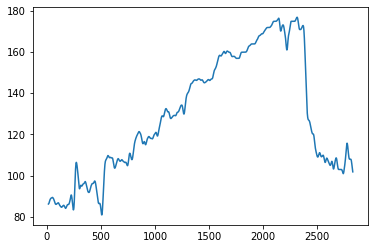

In [24]:
# There is definitely a trend (The test keeps getting harder!)
df1_inc['HR'].plot();

In [25]:
# Add a negligible amount to columns that contain 0 values in order to prevent NaNs when using pct_change
df1_inc['Power'] = df1_inc['Power'] + 0.0001
df1_inc['Cadence'] = df1_inc['Cadence'] + 0.0001

# This should get rid of trend
hr_changes = df1_inc.pct_change()

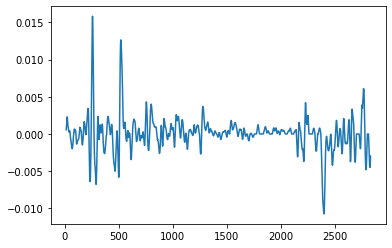

In [26]:
hr_changes['HR'].plot();

### Train, Test, Split, and Modeling

In [27]:
hr_changes.dtypes

time       float64
Power      float64
Oxygen     float64
Cadence    float64
HR         float64
RF         float64
dtype: object

In [28]:
hr_changes.isnull().sum()

time       15
Power      15
Oxygen     15
Cadence    15
HR         15
RF         15
dtype: int64

In [29]:
hr_changes.dropna(inplace= True)

In [30]:
# Create X and y
X = hr_changes.drop(columns= ['HR'])
y = hr_changes['HR'].values

In [31]:
X

time  Power    Oxygen  Cadence        RF
15    0.100000    0.0 -0.031149      0.0 -0.008247
16    0.090909    0.0 -0.024884      0.0 -0.009927
17    0.083333    0.0 -0.017396      0.0 -0.011770
18    0.076923    0.0 -0.010619      0.0 -0.012263
19    0.071429    0.0 -0.004619      0.0 -0.011343
...        ...    ...       ...      ...       ...
2826  0.000354    0.0  0.009232      0.0 -0.005497
2827  0.000354    0.0  0.011928      0.0 -0.004623
2828  0.000354    0.0  0.014463      0.0 -0.003215
2829  0.000354    0.0  0.017510      0.0 -0.001173
2830  0.000354    0.0  0.020830      0.0  0.001664

[2816 rows x 5 columns]

In [32]:
X_train

array([[       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       ...,
       [1.        , 0.94432725, 1.        , 0.97932255, 0.78493663],
       [1.        , 0.94351188, 1.        , 0.97932255, 0.78550073],
       [1.        , 0.94368471, 1.        , 0.97932255, 0.78648791]])

In [33]:
# Scale
mm_scaler = MinMaxScaler()
X_train_sc = mm_scaler.fit_transform(X_train)
X_test_sc = mm_scaler.fit_transform(X_test)
y_train_sc = mm_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_sc = mm_scaler.fit_transform(y_test.reshape(-1, 1))

In [34]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train_sc, length=5, batch_size=64)

# Create test sequences
test_sequences = TimeseriesGenerator(X_test_sc, y_test_sc, length=5, batch_size=64)

In [35]:
train_sequences[0][0].shape

(64, 5, 5)

In [36]:
#train_sequences[1][0].shape # shape of second batch

In [37]:
#train_sequences[0][1] # y first batch

In [38]:
#train_sequences[1][1] # y second batch

In [39]:
# RNN Design

model = Sequential()

model.add(GRU(8, input_shape=(5, 4), return_sequences=True)) # True if the next layer is RNN
model.add(GRU(8, return_sequences=False)) # False if the next layer is Dense
model.add(Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer=Adam(lr=.0005), metrics= 'mse')

In [40]:
res = model.fit(train_sequences, 
                epochs=500, 
                validation_data=test_sequences, 
                shuffle= False,
                #callbacks = [early_stopping]
               )

Epoch 1/500
36/36 [==============================] - 1s 22ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/500
36/36 [==============================] - 0s 6ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/500
36/36 [==============================] - 0s 7ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/500
36/36 [============================

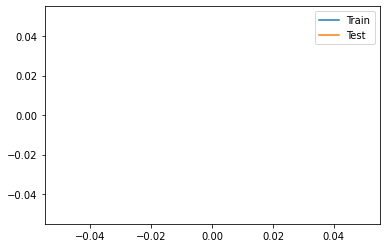

In [41]:
plt.plot(res.history['loss'], label= 'Train')
plt.plot(res.history['val_loss'], label= 'Test')
plt.legend()
#plt.ylim(0, .01);

In [42]:
model.evaluate(test_sequences)

9/9 [==============================] - 0s 2ms/step - loss: nan - mse: nan


[nan, nan]

In [43]:
train_preds = model.predict(train_sequences)
test_preds = model.predict(test_sequences)

In [44]:
r2_score(y_train_sc[5:], train_preds), r2_score(y_test_sc[5:], test_preds)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
preds_df = pd.DataFrame(predictions)
preds_df.head(50)

In [ ]:
# https://www.tutorialguruji.com/python/pandas-how-to-revert-pct_change-to-the-original-value-with-the-initial-value/
preds_df.add(1,fill_value=0).cumprod()

In [ ]:
pd.DataFrame(y_test[3:])

In [ ]:
ss.inverse_transform(preds_df)

In [ ]:
# This is the original scaled X_train and X_test data
ss.inverse_transform(Z_train)

In [ ]:
ss.inverse_transform(Z_test)

In [ ]:
# ideas - use a batch size that is the size of your entire df, 